<a href="https://colab.research.google.com/github/uncertainity/uncertainity/blob/main/Manga_easyocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install easyocr

     |████████████████████████████████| 63.6 MB 65 kB/s 
     |████████████████████████████████| 47.8 MB 1.8 MB/s 


In [ ]:
! pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 152 kB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


In [ ]:
import numpy as np
import cv2
import easyocr
from matplotlib import pyplot as plt

In [ ]:
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
reader = easyocr.Reader(["en"]) #// Switch language #//

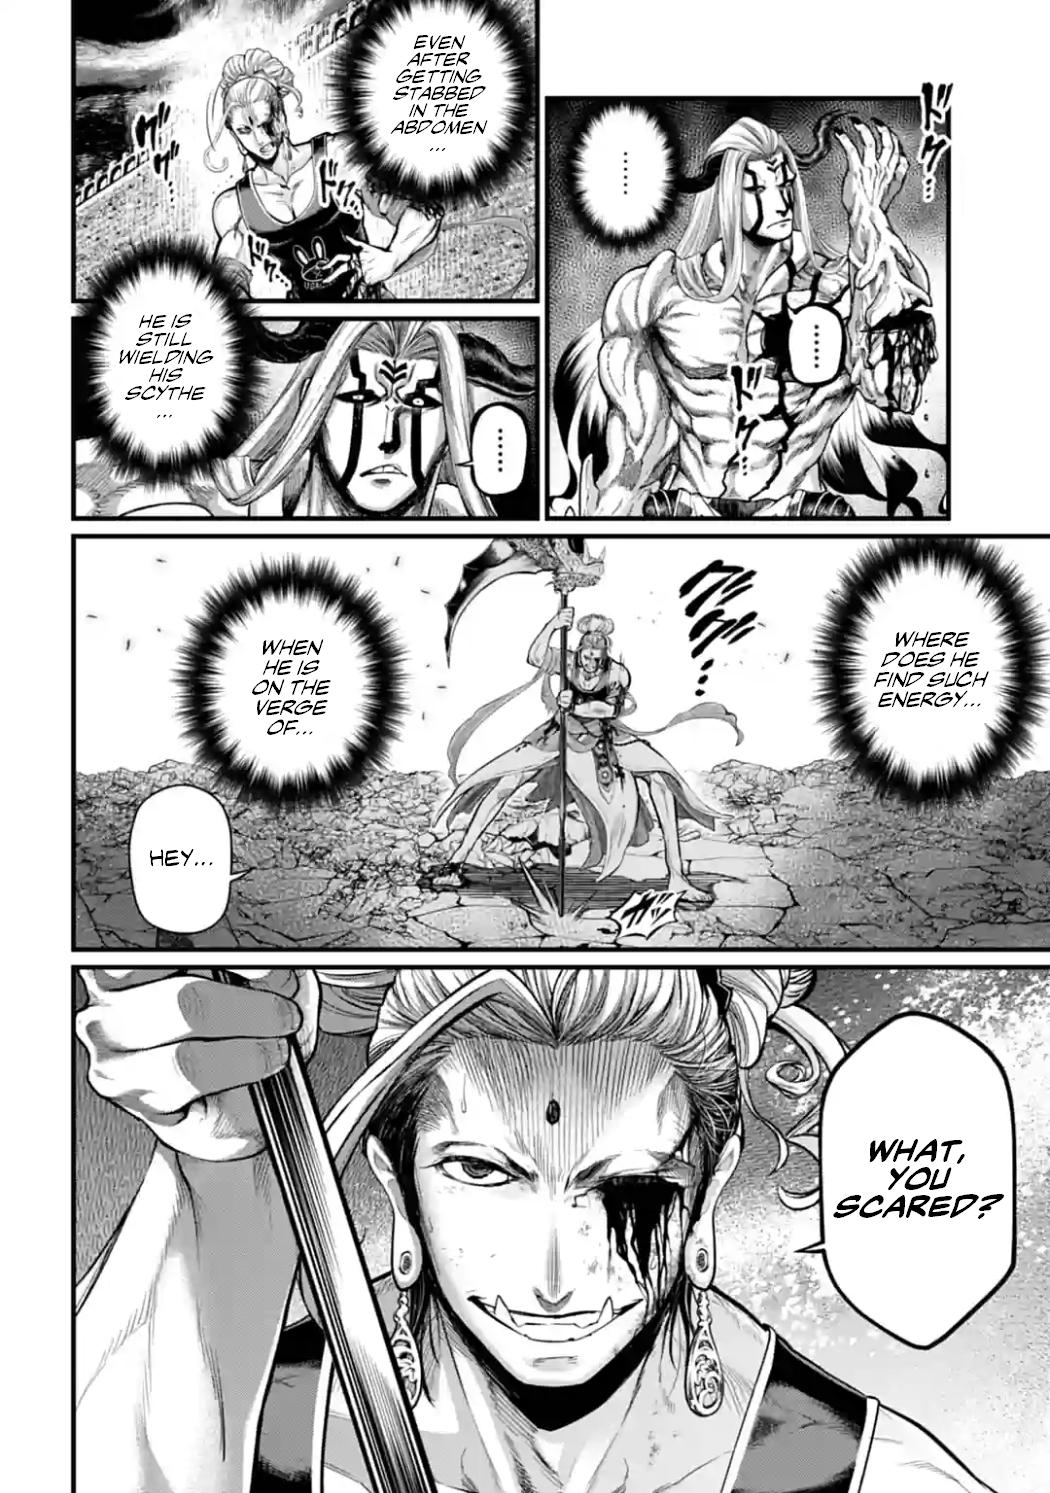

In [ ]:
#// Download the image #//
filepath = "/content/drive/MyDrive/english_1.jpg"
image = cv2.imread(filepath)
cv2_imshow(image)

In [ ]:
def max_min(coord):
  x_min,y_min = [min(idx) for idx in zip(*coord)] 
  x_max,y_max = [max(idx) for idx in zip(*coord)]
  return (x_min,y_min),(x_max,y_max)


In [ ]:
def break_parts(output):
  minimum_coord = []
  maximum_coord = []
  coord_list = []
  mid_val = np.zeros((len(output),2))
  text = []
  for i in range(len(output)):
    coord = output[i][0]
    coord_list.append(coord)
    (x_min,y_min),(x_max,y_max) = max_min(coord)
    minimum_coord.append((x_min,y_min))
    maximum_coord.append((x_max,y_max))
    mid_val[i,0],mid_val[i,1] = (x_min + x_max)/2,(y_min + y_max)/2
    text.append(output[i][1])
  return minimum_coord,maximum_coord,mid_val,text,coord_list

In [ ]:
def distance(a,b):
  return ((a[0] - b[0])**2 + (a[1] - b[1])**2)**0.5

In [ ]:
def preprocess_1(distances,indices,threshold):

  if np.count_nonzero(distances > threshold) > 0:
    pos_x = np.where(distances > threshold)[0]
    pos_y = np.where(distances > threshold)[1]
    for i in range(pos_x.shape[0]):
      indices[int(pos_x[i]),int(pos_y[i])] = -1

  l = []
  for i in range(indices.shape[0]):
    print("i:",i)
    n = np.array([-2])
    k = i
    for j in range(indices.shape[0]):
      if np.count_nonzero(indices[j] == max(indices[k])) > 0:
        if np.count_nonzero(indices[j] == -1) > 0:
          u = indices[j]
          u.sort()
          p_neg = np.where(indices[j] == -1)[0][-1]
          u = indices[j][p_neg+1:]
        n = np.concatenate((n,indices[j]),axis = 0)
        k = j
    n = n[1:]
    n = np.unique(n)
    if np.count_nonzero(n == -1) > 0:
      p_neg = np.where(n == -1)[0][0]
      n = n[p_neg + 1:]
    
    
    l.append(n)
    print(n)
    print("--------------")
  return l
    

In [ ]:
def array_check(ar_a,ar_b):
  for elements in ar_b:
    if np.count_nonzero(ar_a == elements) == 0:
      return False
  return True


In [ ]:
def preprocess_2(l):
  idx_not_check = []
  f_list = []
  for i in range(len(l)):
    m = -1
    if i not in idx_not_check:
      for j in range(len(l)):
        if i == j:
          continue
        check= array_check(l[i],l[j])
        if check == True:
          idx_not_check.append(j)
          m = i
        if check == False:
          if array_check(l[j],l[i]) == True:
            m = -1
            break
      if m > -1:
        f_list.append(l[i])
  return f_list

In [ ]:
def sentence_construction(f_list,text):
  sentences = []
  for i in range(len(f_list)):
    s = ""
    for words in f_list[i]:
      s = s + text[words] + " "
    s = s[:-1]
    sentences.append(s)
  return sentences


In [ ]:
def geometry_construction(f_list,coord_list):
  geometry = []
  for i in range(len(f_list)):
    local = []
    for pos in f_list[i]:
      local.append(coord_list[pos])
    flat_local = [item for sublist in local for item in sublist]
    geometry.append(flat_local)
  return geometry

In [ ]:
def sentence_box(f_list,geometry):
  sentence_coords = []
  for i in range(len(geometry)):
    (x_min,y_min),(x_max,y_max) = max_min(geometry[i])
    sentence_coords.append([(x_min,y_min),(x_max,y_max)])
  return sentence_coords

In [ ]:
from sklearn.neighbors import NearestNeighbors
def build(filepath,threshold = 150):

  output = reader.readtext(filepath)
  minimum_coord,maximum_coord,mid_val,text,coord_list = break_parts(output)
  nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(mid_val)
  distances, indices = nbrs.kneighbors(mid_val)
  l = preprocess_1(distances,indices,threshold)
  f_list = preprocess_2(l)
  sentences = sentence_construction(f_list,text)
  geometry = geometry_construction(f_list,coord_list)
  sentence_coords = sentence_box(f_list,geometry)

  return minimum_coord,maximum_coord,mid_val,text,coord_list,f_list,sentences,geometry,sentence_coords

In [ ]:
minimum_coord,maximum_coord,mid_val,text,coord_list,f_list,sentences,geometry,sentence_coords = build(filepath)

i: 0
[0 1 2 3 4 5 6]
--------------
i: 1
[0 1 2 3 4 5 6]
--------------
i: 2
[0 1 2 3 4 5 6]
--------------
i: 3
[1 2 3 4 5 6]
--------------
i: 4
[1 2 3 4 5 6]
--------------
i: 5
[1 2 3 4 5 6]
--------------
i: 6
[3 4 5 6]
--------------
i: 7
[ 7  8  9 10 11]
--------------
i: 8
[ 7  8  9 10 11]
--------------
i: 9
[ 7  8  9 10 11]
--------------
i: 10
[ 7  8  9 10 11]
--------------
i: 11
[ 7  8  9 10 11]
--------------
i: 12
[12 15 17 19]
--------------
i: 13
[13 14 16 18 20]
--------------
i: 14
[13 14 16 18 20]
--------------
i: 15
[12 15 17 19]
--------------
i: 16
[13 14 16 18 20]
--------------
i: 17
[12 15 17 19]
--------------
i: 18
[13 14 16 18 20]
--------------
i: 19
[12 15 17 19]
--------------
i: 20
[13 14 16 18 20]
--------------
i: 21
[21]
--------------
i: 22
[22 23 24]
--------------
i: 23
[22 23 24]
--------------
i: 24
[22 23 24]
--------------


In [ ]:
sentence_coords

[[(309, 30), (489, 225)],
 [(117, 311), (215, 403)],
 [(873, 629), (989, 711)],
 [(251, 636), (331, 737)],
 [(831, 1136), (1007, 1225)]]

In [ ]:
sentences

['EvEN AfteR GetTING STABBED IN THE ABDOMen Ms',
 'Heis Still WieLDinG His SCYTHE',
 'WHERE DOES HE FinD SuCh ENERGY .',
 'WHEN HEIS ON THE VERGE Of;',
 'WHAT; YOU SCARED?']

In [ ]:
f_list

[array([0, 1, 2, 3, 4, 5, 6]),
 array([ 7,  8,  9, 10, 11]),
 array([12, 15, 17, 19]),
 array([13, 14, 16, 18, 20]),
 array([22, 23, 24])]

In [ ]:
coord_list

[[[412, 30], [468, 30], [468, 54], [412, 54]],
 [[407, 49], [471, 49], [471, 69], [407, 69]],
 [[393, 63], [484, 63], [484, 88], [393, 88]],
 [[393, 83], [487, 83], [487, 103], [393, 103]],
 [[407, 101], [471, 101], [471, 119], [407, 119]],
 [[391, 117], [489, 117], [489, 137], [391, 137]],
 [[309, 153], [371, 153], [371, 225], [309, 225]],
 [[137, 311], [193, 311], [193, 331], [137, 331]],
 [[135, 329], [195, 329], [195, 349], [135, 349]],
 [[117, 347], [215, 347], [215, 367], [117, 367]],
 [[147, 365], [185, 365], [185, 385], [147, 385]],
 [[123, 383], [207, 383], [207, 403], [123, 403]],
 [[893, 629], [971, 629], [971, 649], [893, 649]],
 [[260, 636], [326, 636], [326, 660], [260, 660]],
 [[261, 657], [321, 657], [321, 677], [261, 677]],
 [[879, 649], [981, 649], [981, 669], [879, 669]],
 [[251, 677], [331, 677], [331, 697], [251, 697]],
 [[873, 669], [989, 669], [989, 689], [873, 689]],
 [[252, 696], [330, 696], [330, 720], [252, 720]],
 [[876, 687], [984, 687], [984, 711], [876, 7

In [ ]:
text

['EvEN',
 'AfteR',
 'GetTING',
 'STABBED',
 'IN THE',
 'ABDOMen',
 'Ms',
 'Heis',
 'Still',
 'WieLDinG',
 'His',
 'SCYTHE',
 'WHERE',
 'WHEN',
 'HEIS',
 'DOES HE',
 'ON THE',
 'FinD SuCh',
 'VERGE',
 'ENERGY .',
 'Of;',
 'Hey,',
 'WHAT;',
 'YOU',
 'SCARED?']